In [4]:
import openml
import pandas as pd


def check_class_imbalance(threshold=0.8):
    # Get datasets from OpenML Collection with ID 99
    datasets = openml.study.get_suite(99)  # Suite ID 99

    # List to store datasets with imbalance
    imbalanced_datasets = []

    print("Checking for class imbalance in OpenML Collection 99...\n")

    for dataset_id in datasets.data:
        try:
            # Download the dataset
            dataset = openml.datasets.get_dataset(dataset_id)
            X, y, _, attributes = dataset.get_data(
                target=dataset.default_target_attribute
            )

            # Ensure the target variable is categorical
            if not isinstance(y, pd.Categorical):
                y = pd.Categorical(y)

            # Calculate class distribution
            class_counts = y.value_counts()  # Absolute counts
            total = class_counts.sum()  # Total number of instances
            class_proportions = class_counts / total  # Normalized proportions
            max_class_proportion = class_proportions.max()

            # Check for imbalance
            if max_class_proportion >= threshold:
                imbalanced_datasets.append(
                    {
                        "Dataset ID": dataset_id,
                        "Dataset Name": dataset.name,
                        "Max Class Proportion": max_class_proportion,
                        "Class Distribution": class_proportions.to_dict(),
                    }
                )

        except Exception as e:
            print(f"Error processing dataset {dataset_id}: {e}")
            continue

    # Sort the imbalanced datasets by max class proportion in descending order
    imbalanced_datasets = sorted(
        imbalanced_datasets, key=lambda x: x["Max Class Proportion"], reverse=True
    )

    # Print results
    if imbalanced_datasets:
        print("Datasets with class imbalance greater than the threshold:\n")
        for dataset in imbalanced_datasets:
            print(f"Dataset ID: {dataset['Dataset ID']}")
            print(f"Dataset Name: {dataset['Dataset Name']}")
            print(f"Max Class Proportion: {dataset['Max Class Proportion']:.2%}")
            print("Class Distribution:")
            for cls, proportion in dataset["Class Distribution"].items():
                print(f"  {cls}: {proportion:.2%}")
            print()
    else:
        print("No datasets found with class imbalance greater than the threshold.")

    return imbalanced_datasets


# Run the script
imbalanced_datasets = check_class_imbalance(threshold=0.8)

Checking for class imbalance in OpenML Collection 99...

Datasets with class imbalance greater than the threshold:

Dataset ID: 40983
Dataset Name: wilt
Max Class Proportion: 94.61%
Class Distribution:
  1: 94.61%
  2: 5.39%

Dataset ID: 38
Dataset Name: sick
Max Class Proportion: 93.88%
Class Distribution:
  negative: 93.88%
  sick: 6.12%

Dataset ID: 1487
Dataset Name: ozone-level-8hr
Max Class Proportion: 93.69%
Class Distribution:
  1: 93.69%
  2: 6.31%

Dataset ID: 1068
Dataset Name: pc1
Max Class Proportion: 93.06%
Class Distribution:
  False: 93.06%
  True: 6.94%

Dataset ID: 40994
Dataset Name: climate-model-simulation-crashes
Max Class Proportion: 91.48%
Class Distribution:
  0: 8.52%
  1: 91.48%

Dataset ID: 1050
Dataset Name: pc3
Max Class Proportion: 89.76%
Class Distribution:
  False: 89.76%
  True: 10.24%

Dataset ID: 1461
Dataset Name: bank-marketing
Max Class Proportion: 88.30%
Class Distribution:
  1: 88.30%
  2: 11.70%

Dataset ID: 1049
Dataset Name: pc4
Max Class Pro

In [5]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def MySmote(X, y, minority_class, k_neighbors=5, n_samples=100, max_distance=None):
    """
    Implementa uma versão personalizada do SMOTE.

    Parâmetros:
    - X (array-like): Dados de entrada (features).
    - y (array-like): Rótulos correspondentes.
    - minority_class: Classe minoritária (exemplo: 1 ou "positive").
    - k_neighbors (int): Número de vizinhos a considerar para gerar novos exemplos.
    - n_samples (int): Número de exemplos sintéticos a serem gerados.
    - max_distance (float): Distância máxima permitida para geração de exemplos sintéticos.

    Retorna:
    - X_new (numpy.ndarray): Conjunto de dados com exemplos sintéticos adicionados.
    - y_new (numpy.ndarray): Rótulos correspondentes ao novo conjunto de dados.
    """
    # Separar classe minoritária
    X_minority = X[y == minority_class]
    if len(X_minority) == 0:
        raise ValueError("Não há dados da classe minoritária.")

    # Identificar k-vizinhos mais próximos na classe minoritária
    nn = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(X_minority)
    distances, indices = nn.kneighbors(X_minority)

    # Criar novos exemplos sintéticos
    synthetic_samples = []
    for _ in range(n_samples):
        # Selecionar um ponto minoritário aleatoriamente
        idx = np.random.randint(0, X_minority.shape[0])
        x_original = X_minority[idx]

        # Selecionar um vizinho próximo aleatório
        neighbor_idx = np.random.choice(
            indices[idx][1:]
        )  # Ignorar o próprio ponto (primeiro vizinho)
        x_neighbor = X_minority[neighbor_idx]

        # Gerar exemplo sintético no segmento entre x_original e x_neighbor
        diff = x_neighbor - x_original
        gap = np.random.rand()  # Número aleatório entre 0 e 1
        synthetic_point = x_original + gap * diff

        # Restringir exemplos com base na distância máxima (se fornecido)
        if max_distance is not None:
            dist = np.linalg.norm(synthetic_point - x_original)
            if dist > max_distance:
                continue  # Pula esta geração

        synthetic_samples.append(synthetic_point)

    # Adicionar exemplos sintéticos aos dados originais
    X_new = np.vstack([X, synthetic_samples])
    y_new = np.hstack([y, [minority_class] * len(synthetic_samples)])

    return X_new, y_new

In [6]:
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek


class TreeNode:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def gini(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities**2)

    def best_split(self, X, y):
        best_gini = 1.0
        best_feature, best_threshold = None, None
        n_features = X.shape[1]

        for feature in range(n_features):
            X_feature = X[:, feature]
            sorted_indices = np.argsort(X_feature)
            X_sorted = X_feature[sorted_indices]
            y_sorted = y[sorted_indices]

            # Identify potential split points
            for i in range(1, len(y_sorted)):
                if y_sorted[i] != y_sorted[i - 1]:
                    threshold = (X_sorted[i] + X_sorted[i - 1]) / 2
                    left_mask = X_sorted < threshold
                    y_left = y_sorted[left_mask]
                    y_right = y_sorted[~left_mask]

                    if len(y_left) == 0 or len(y_right) == 0:
                        continue

                    gini_left = self.gini(y_left)
                    gini_right = self.gini(y_right)
                    gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(
                        y_sorted
                    )

                    if gini < best_gini:
                        best_gini = gini
                        best_feature = feature
                        best_threshold = threshold

        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        num_samples, _ = X.shape
        if (
            self.max_depth is not None and depth >= self.max_depth
        ) or num_samples < self.min_samples_split:
            leaf_value = Counter(y).most_common(1)[0][0]
            return TreeNode(value=leaf_value)

        feature, threshold = self.best_split(X, y)
        if feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return TreeNode(value=leaf_value)

        # Split the data
        left_indices = X[:, feature] < threshold
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[~left_indices], y[~left_indices]

        if len(y_left) == 0 or len(y_right) == 0:
            leaf_value = Counter(y).most_common(1)[0][0]
            return TreeNode(value=leaf_value)

        # Recursively build the left and right subtrees
        left = self.build_tree(X_left, y_left, depth + 1)
        right = self.build_tree(X_right, y_right, depth + 1)
        return TreeNode(feature, threshold, left, right)

    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] < node.threshold:
            return self.predict_sample(x, node.left)
        else:
            return self.predict_sample(x, node.right)

    def predict(self, X):
        return np.array([self.predict_sample(x, self.root) for x in X])


class RandomForest:
    def __init__(
        self,
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        max_features="sqrt",
        smote=False,
        random_state=None,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.smote = smote
        self.random_state = random_state
        self.trees = []

    def bootstrap_sample(self, X, y):
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_sample, y_sample = X[indices], y[indices]

        # Ensure sampled data is still numeric
        if X_sample.dtype == "O" or y_sample.dtype == "O":
            X_sample, y_sample = convert_to_numeric(X_sample, y_sample)

        return X_sample, y_sample

    def fit(self, X, y):
        # Convert to NumPy arrays if they are pandas structures
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values

        # Convert to numeric if necessary
        if X.dtype == "O" or y.dtype == "O":
            X, y = convert_to_numeric(X, y)

        # Apply SMOTE if enabled
        if self.smote:
            sm = SMOTE(sampling_strategy=1, random_state=self.random_state)

            # sm = RandomUnderSampler(random_state=self.random_state)
            # sm = SMOTEENN(random_state=self.random_state)
            # sm = SMOTETomek(random_state=self.random_state)
            # sm = ADASYN(random_state=self.random_state)
            X, y = sm.fit_resample(X, y)

        self.trees = []
        n_features_total = X.shape[1]

        # Determine the number of features to consider at each split
        if self.max_features == "sqrt":
            max_features = int(np.sqrt(n_features_total))
        elif self.max_features == "log2":
            max_features = int(np.log2(n_features_total))
        elif isinstance(self.max_features, int):
            max_features = self.max_features
        elif self.max_features.lower() == "auto":
            max_features = n_features_total
        else:
            raise ValueError("RandomForest.fit: Invalid value for max_features")

        for i in range(self.n_estimators):
            tree = DecisionTree(
                max_depth=self.max_depth, min_samples_split=self.min_samples_split
            )
            if self.smote:
                X_sample, y_sample = X, y
            else:
                X_sample, y_sample = self.bootstrap_sample(X, y)

            # Select random subset of features
            features = np.random.choice(n_features_total, max_features, replace=False)

            # Fit the tree on the sampled data with selected features
            tree.fit(X_sample[:, features], y_sample)

            tree.features = features
            self.trees.append(tree)

    def predict(self, X):
        # Convert to NumPy array if it's a pandas structure
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values

        tree_preds = []
        for i, tree in enumerate(self.trees):
            try:
                preds = tree.predict(X[:, tree.features])
                tree_preds.append(preds)
            except Exception as e:
                print(f"RandomForest.predict: Error predicting with tree {i+1}: {e}")
                raise e

        tree_preds = np.array(tree_preds).T  # Shape: (n_samples, n_estimators)
        y_pred = [Counter(row).most_common(1)[0][0] for row in tree_preds]
        return np.array(y_pred)


# Helper function
def convert_to_numeric(X, y):
    # Convert X to float
    if X.dtype == "O":
        X = X.astype(float)

    # Convert y to integer
    if y.dtype == "O":
        y = y.astype(int)

    return X, y

Dataset ID: 40994

No non-numeric features to encode.

Encoded Target dtype: int8
Target Categories and Codes:
 {'0': np.int8(0), '1': np.int8(1)}

SMOTE Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.31      1.00      0.47         9
           1       1.00      0.80      0.89        99

    accuracy                           0.81       108
   macro avg       0.66      0.90      0.68       108
weighted avg       0.94      0.81      0.85       108


Without SMOTE Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.93      1.00      0.96        99

    accuracy                           0.93       108
   macro avg       0.96      0.56      0.58       108
weighted avg       0.93      0.93      0.90       108



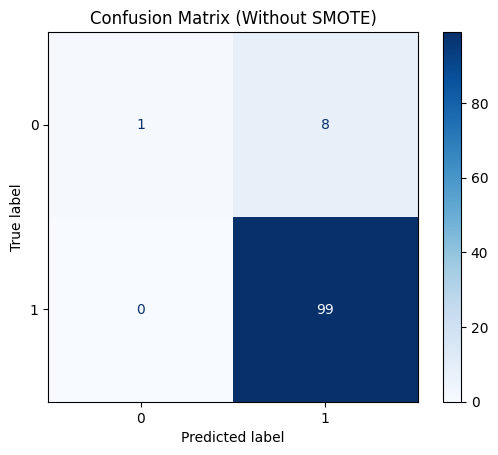

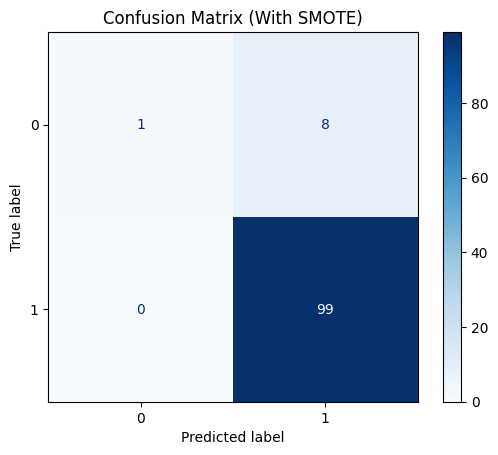

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import openml  # Ensure openml is imported

# Define your custom RandomForest class here or ensure it's imported
# from your_random_forest_module import RandomForest

# Load the datasets from OpenML Collection 99
dataset_id = imbalanced_datasets[4]["Dataset ID"]
print("Dataset ID:", dataset_id)
data = openml.datasets.get_dataset(dataset_id)

X, y, _, _ = data.get_data(
    dataset_format="dataframe", target=data.default_target_attribute
)

# Combine X and y for consistent row removal
combined_data = pd.concat([X, y], axis=1)

combined_data_clean = combined_data.dropna()

# Separate X_clean and y_clean
X_clean = combined_data_clean.drop(
    columns=[y.name]
)  # Replace y.name with the actual target column name if different
y_clean = combined_data_clean[y.name]

# Update X and y to cleaned versions
X, y = X_clean, y_clean

# Identify non-numeric columns in X
non_numeric_cols = X.select_dtypes(include=["object", "category"]).columns

# Encode categorical features by converting them to categorical codes
if len(non_numeric_cols) > 0:
    for col in non_numeric_cols:
        X[col] = X[col].astype("category").cat.codes
        print(f"\nEncoded '{col}' with codes:\n", X[col].unique())
    print("\nAfter Encoding Feature dtypes:\n", X.dtypes)
else:
    print("\nNo non-numeric features to encode.")

# Encode target variable using Pandas Categorical Codes if it's non-numeric
if y.dtype == "object" or y.dtype.name == "category":
    y = y.astype("category")
    y_codes = y.cat.codes
    print("\nEncoded Target dtype:", y_codes.dtype)
    print(
        "Target Categories and Codes:\n", dict(zip(y.cat.categories, y_codes.unique()))
    )
    y = y_codes

max_accuracy = 0
max_random_state = 0

random_state = 99

# Split the data with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state, stratify=y
)

# Initialize RandomForest with SMOTE
rf = RandomForest(
    n_estimators=15,
    max_depth=5,
    smote=True,
    random_state=random_state,
)

# Fit the model
rf.fit(X_train, y_train)

# Predict
predictions = rf.predict(X_test)

# Calculate accuracy
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"\nSMOTE Accuracy: {accuracy:.2f}")

# Calculate precision, recall, and F1 score
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions)

print("\nClassification Report:")
print(report)

rf = RandomForest(
    n_estimators=15,
    max_depth=5,
    smote=False,
    random_state=random_state,
)

# Fit the model
rf.fit(X_train, y_train)

# Predict
predictions = rf.predict(X_test)

# Calculate accuracy
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"\nWithout SMOTE Accuracy: {accuracy:.2f}")

report = classification_report(y_test, predictions)

print("\nClassification Report:")
print(report)

# Previsões do modelo (pode ser com ou sem SMOTE, dependendo de qual você escolher)
predictions = rf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()